### Import packages

In [36]:
# Basic Imports
import pandas as pd
import numpy as np 

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras
import itertools
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm
from itertools import product

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [37]:
df = pd.read_csv('Data/processed_df.csv')
cv = pd.read_csv('Data/cv_processed_df.csv')
df.head()

,return,no_delivery,is_female,is_male,is_bday,most_returned_item,least_returned_item,most_returned_color,least_returned_color,log_item_price,...,item_size_l,item_size_m,item_size_s,item_size_unsized,item_size_xl,item_size_xs,item_size_xxl,item_size_xxxl,user_return_rate,brand_return_rate
0,0,0,1,0,0,0,0,0,0,-0.090200,...,0,0,0,0,0,0,0,1,0.000000,0.361744
1,0,1,1,0,0,0,1,0,0,-1.274292,...,0,0,0,0,0,0,0,0,0.000000,0.361744
2,1,0,1,0,0,0,0,0,0,0.603400,...,0,0,0,0,0,0,1,0,0.615385,0.541545
3,0,0,1,0,0,1,0,0,0,0.946548,...,0,0,0,0,0,0,1,0,0.615385,0.541545
4,1,0,1,0,0,0,0,0,0,-1.589747,...,0,0,0,0,0,0,1,0,0.615385,0.370151


In [38]:
df.columns

Index(['return', 'no_delivery', 'is_female', 'is_male', 'is_bday',
       'most_returned_item', 'least_returned_item', 'most_returned_color',
       'least_returned_color', 'log_item_price', 'log_no_items', 'log_age',
       'log_avg_freq_purchases', 'user_state_Baden-Wuerttemberg',
       'user_state_Bavaria', 'user_state_Berlin', 'user_state_Brandenburg',
       'user_state_Bremen', 'user_state_Hamburg', 'user_state_Hesse',
       'user_state_Lower Saxony', 'user_state_Mecklenburg-Western Pomerania',
       'user_state_North Rhine-Westphalia', 'user_state_Rhineland-Palatinate',
       'user_state_Saarland', 'user_state_Saxony', 'user_state_Saxony-Anhalt',
       'user_state_Schleswig-Holstein', 'user_state_Thuringia',
       'item_size_child', 'item_size_l', 'item_size_m', 'item_size_s',
       'item_size_unsized', 'item_size_xl', 'item_size_xs', 'item_size_xxl',
       'item_size_xxxl', 'user_return_rate', 'brand_return_rate'],
      dtype='object')

##### Cross Validation Preparation

In [39]:
def prepare_kfold_data(X_train, y_train, k=5, default_fill_value=0.5):
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    data_arrays = []

    for train_index, val_index in kf.split(X_train):
        # Step 1: Split data into train and validation folds
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Step 2: Perform preprocessing on train fold
        user_return_rates = X_train_fold.groupby('user_id')['return'].mean()
        brand_return_rates = X_train_fold.groupby('brand_id')['return'].mean()
        
        X_train_fold['user_return_rate'] = X_train_fold['user_id'].map(user_return_rates)
        X_train_fold['brand_return_rate'] = X_train_fold['brand_id'].map(brand_return_rates)
        
        # Step 3: Map values to validation fold
        X_val_fold['user_return_rate'] = X_val_fold['user_id'].map(user_return_rates).fillna(default_fill_value)
        X_val_fold['brand_return_rate'] = X_val_fold['brand_id'].map(brand_return_rates).fillna(default_fill_value)
        
        # Step 4: Drop unnecessary columns
        X_train_fold.drop(['return', 'user_id', 'brand_id'], axis=1, inplace=True)
        X_val_fold.drop(['return', 'user_id', 'brand_id'], axis=1, inplace=True)
        
        # Append data arrays
        data_arrays.append((X_train_fold, y_train_fold, X_val_fold, y_val_fold))

    return data_arrays

In [40]:
# Create train test split for CV evaluation
X = cv
y = cv['return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get kfold data
kfold_data = prepare_kfold_data(X_train, y_train, k=5, default_fill_value=0.5)

/var/folders/4f/3w_37fps2jl_9bqnhfpl8d8h0000gn/T/ipykernel_1125/32175107.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['user_return_rate'] = X_train_fold['user_id'].map(user_return_rates)
/var/folders/4f/3w_37fps2jl_9bqnhfpl8d8h0000gn/T/ipykernel_1125/32175107.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['brand_return_rate'] = X_train_fold['brand_id'].map(brand_return_rates)
/var/folders/4f/3w_37fps2jl_9bqnhfpl8d8h0000gn/T/ipykernel_1125/32175107.py:19: SettingWithCo

In [41]:
# Look at kfold data
kfold_data[0]

(       no_delivery  is_female  is_male  is_bday  most_returned_item  \
 64470            0          1        0        0                   0   
 45557            0          1        0        0                   0   
 27614            0          1        0        0                   1   
 13568            0          1        0        0                   0   
 92726            1          1        0        0                   0   
 ...            ...        ...      ...      ...                 ...   
 82386            0          1        0        0                   0   
 6265             0          1        0        0                   1   
 54886            0          1        0        0                   0   
 860              0          1        0        0                   0   
 15795            1          1        0        0                   0   
 
        least_returned_item  most_returned_color  least_returned_color  \
 64470                    0                    0            

##### Model Evaluation Preparation

In [42]:
# Create train test split for model evaluation
X = df.drop('return', axis=1)
y = df['return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(79999, 39)
(79999,)
(20000, 39)
(20000,)


##### Gridsearch Preparation

In [43]:
def generate_param_combinations(params):
    """
    Generates all possible unique parameter combinations.
    
    Parameters:
        params (dict): A dictionary where keys are parameter names and values are lists of possible values for each parameter.
    
    Yields:
        dict: A dictionary representing a unique parameter combination.
    """
    # Check if params is a dictionary
    if not isinstance(params, dict):
        raise ValueError("params must be a dictionary")

    # Check if all values in params are lists
    if not all(isinstance(v, list) for v in params.values()):
        raise ValueError("All values in params must be lists")

    # Generate parameter combinations
    keys = list(params.keys())
    value_combinations = itertools.product(*params.values())
    
    for values in value_combinations:
        yield dict(zip(keys, values))

# SKLearn Grid Search 
def custom_grid_search_auc(model, params, kfold_data):
    best_score = 0.0
    best_params = None

    for param_set in generate_param_combinations(params):

        avg_score = 0.0
        
        for fold, (X_train_fold, y_train_fold, X_val_fold, y_val_fold) in enumerate(kfold_data):
            model.set_params(**param_set)
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict_proba(X_val_fold)[:, 1]
            fold_score = roc_auc_score(y_val_fold, y_pred)
            avg_score += fold_score
        
        avg_score /= len(kfold_data)
        print("Params:", param_set, "| Avg. AUC Score:", round(avg_score,5))
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = param_set
            
    print()
    print("Params Avg. AUC Score:", round(best_score,5))
    print("Best Params:", best_params)

    return None

# XGBoost Grid Search 
def custom_grid_search_xgb_auc(params, kfold_data):
    best_score = 0.0
    best_params = None

    for param_set in generate_param_combinations(params):
        avg_score = 0.0
        for fold, (X_train_fold, y_train_fold, X_val_fold, y_val_fold) in enumerate(kfold_data):
            xgb = XGBClassifier(**param_set)
            xgb.fit(X_train_fold, y_train_fold)
            y_pred = xgb.predict_proba(X_val_fold)[:, 1]
            fold_score = roc_auc_score(y_val_fold, y_pred)
            avg_score += fold_score
        
        avg_score /= len(kfold_data)
        print("Params:", param_set, "| Avg. AUC Score:", round(avg_score,5))
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = param_set
            
    print()
    print("Params Avg. AUC Score:", round(best_score,5))
    print("Best Params:", best_params)

    return None

# No Probability Grid Search 
def custom_grid_search_acc(model, params, kfold_data):
    best_score = 0.0
    best_params = None

    for param_set in generate_param_combinations(params):
        
        avg_score = 0.0
        
        for fold, (X_train_fold, y_train_fold, X_val_fold, y_val_fold) in enumerate(kfold_data):
            model.set_params(**param_set)
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            fold_score = balanced_accuracy_score(y_val_fold, y_pred)
            avg_score += fold_score
        
        avg_score /= len(kfold_data)
        print("Params:", param_set, "| Avg. Acc Score:", round(avg_score,5))
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = param_set
            
    print()
    print("Params Avg. Acc Score:", round(best_score,5))
    print("Best Params:", best_params)

    return None

DNN

In [44]:
def custom_grid_search_dnn_auc(dnn_model, params, kfold_data):
    best_score = 0.0
    best_params = None
    best_history = None

    for param_set in generate_param_combinations(params):
        avg_score = 0.0
        histories = []  # Store training histories for each fold
        
        for fold, (X_train_fold, y_train_fold, X_val_fold, y_val_fold) in enumerate(kfold_data):
            
            dnn_model.add(Dense(param_set['input'], input_shape=(X_train_fold.shape[1],)))
            dnn_model.add(Dense(param_set['hidden'], activation='relu')) # hidden layer 
            dnn_model.add(Dense(1, activation='sigmoid'))  # Output layer
            dnn_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer="adam")

            history = dnn_model.fit(X_train_fold, y_train_fold, epochs=param_set['epochs'], batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))
            histories.append(history)  # Store history
            
            y_pred = dnn_model.predict(X_val_fold)
            auc_score = roc_auc_score(y_val_fold, y_pred)
            avg_score += auc_score
            
        avg_score /= len(kfold_data)
        print("Params:", param_set, "| Avg. AUC Score:", round(avg_score, 5))
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = param_set
            best_history = histories
            
    print()
    print("Params Avg. AUC Score:", round(best_score, 5))
    print("Best Params:", best_params)

    return best_history

def generate_all_possible_param_combinations(params):
    """
    Generates all possible unique parameter combinations within the specified range.
    
    Parameters:
        params (dict): A dictionary where keys are parameter names and values are lists of two elements
                       representing the lower and upper bounds of the range for each parameter.
    
    Yields:
        dict: A dictionary representing a unique parameter combination.
    """
    # Check if params is a dictionary
    if not isinstance(params, dict):
        raise ValueError("params must be a dictionary")

    # Check if all values in params are lists of two elements
    if not all(isinstance(v, list) and len(v) == 2 for v in params.values()):
        raise ValueError("All values in params must be lists of two elements")

    # Generate parameter combinations
    param_names = list(params.keys())
    param_value_ranges = [range(v[0], v[1] + 1) for v in params.values()]
    param_combinations = product(*param_value_ranges)

    # Iterate through each combination of parameters
    for values in param_combinations:
        yield {name: value for name, value in zip(param_names, values)}


##### Evaluation Functions

In [45]:
# Get metrics for model without probabilities
def evaluate_model_binary(fitted_model, x_test, y_test):
    y_pred = fitted_model.predict(x_test)  # Predict binary labels
    
    auc = roc_auc_score(y_test, y_pred)
    accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics_dict = {
        'AUC': auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    return metrics_dict


# Get metrics for model with probabilities
def evaluate_model_probability(fitted_model, x_test, y_test, threshold=0.5):
    y_pred_probs = fitted_model.predict_proba(x_test)[:, 1]
    y_pred = (y_pred_probs > threshold).astype(int)
    
    auc = roc_auc_score(y_test, y_pred_probs)
    accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics_dict = {
        'AUC': auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    return metrics_dict

# DNN - Get metrics for model with probabilities
def evaluate_dnn_probability(fitted_model, x_test, y_test, threshold=0.5):
    y_pred_probs = fitted_model.predict(x_test)
    y_pred = (y_pred_probs > threshold).astype(int)
    
    auc = roc_auc_score(y_test, y_pred_probs)
    accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics_dict = {
        'AUC': auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    return metrics_dict

# Logistic Regression without Interaction Terms

##### Baseline

In [51]:
logreg_baseline = LogisticRegression(solver='saga', penalty=None, random_state=42)
logreg_baseline.fit(X_train, y_train)

evaluate_model_probability(logreg_baseline, X_test, y_test)

/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'AUC': 0.7566285328223896,
 'Accuracy': 0.6846306320248767,
 'Precision': 0.6513761467889908,
 'Recall': 0.6649405024239753,
 'F1 Score': 0.658088435745052}

##### Tuning

Regularization

In [52]:
# Initialize Model
logreg = LogisticRegression(penalty='l1', solver='saga', random_state=42)

In [53]:
# Step 1
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

custom_grid_search_auc(logreg, param_grid, kfold_data)

Params: {'C': 0.001} | Avg. AUC Score: 0.70893
Params: {'C': 0.01} | Avg. AUC Score: 0.73944
Params: {'C': 0.1} | Avg. AUC Score: 0.74511
Params: {'C': 1} | Avg. AUC Score: 0.74555


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 100} | Avg. AUC Score: 0.74557

Params Avg. AUC Score: 0.74557
Best Params: {'C': 100}


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [54]:
# Re-Initialize Model
logreg = LogisticRegression(penalty='l2', solver='saga', random_state=42)

# Step 2
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

custom_grid_search_auc(logreg, param_grid, kfold_data)

Params: {'C': 0.001} | Avg. AUC Score: 0.74149
Params: {'C': 0.01} | Avg. AUC Score: 0.73986
Params: {'C': 0.1} | Avg. AUC Score: 0.74385
Params: {'C': 1} | Avg. AUC Score: 0.74552


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 100} | Avg. AUC Score: 0.74557

Params Avg. AUC Score: 0.74557
Best Params: {'C': 10}


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
# Re-Initialize Model
logreg = LogisticRegression(penalty='elasticnet', solver='saga', random_state=42)

# Step 3
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9] 
}

custom_grid_search_auc(logreg, param_grid, kfold_data)

Params: {'C': 0.001, 'l1_ratio': 0.1} | Avg. AUC Score: 0.73912
Params: {'C': 0.001, 'l1_ratio': 0.3} | Avg. AUC Score: 0.73411
Params: {'C': 0.001, 'l1_ratio': 0.5} | Avg. AUC Score: 0.72807
Params: {'C': 0.001, 'l1_ratio': 0.7} | Avg. AUC Score: 0.72163
Params: {'C': 0.001, 'l1_ratio': 0.9} | Avg. AUC Score: 0.71382
Params: {'C': 0.01, 'l1_ratio': 0.1} | Avg. AUC Score: 0.73963
Params: {'C': 0.01, 'l1_ratio': 0.3} | Avg. AUC Score: 0.7393
Params: {'C': 0.01, 'l1_ratio': 0.5} | Avg. AUC Score: 0.73907
Params: {'C': 0.01, 'l1_ratio': 0.7} | Avg. AUC Score: 0.739
Params: {'C': 0.01, 'l1_ratio': 0.9} | Avg. AUC Score: 0.73919
Params: {'C': 0.1, 'l1_ratio': 0.1} | Avg. AUC Score: 0.74391
Params: {'C': 0.1, 'l1_ratio': 0.3} | Avg. AUC Score: 0.74404
Params: {'C': 0.1, 'l1_ratio': 0.5} | Avg. AUC Score: 0.74423
Params: {'C': 0.1, 'l1_ratio': 0.7} | Avg. AUC Score: 0.74448
Params: {'C': 0.1, 'l1_ratio': 0.9} | Avg. AUC Score: 0.74486
Params: {'C': 1, 'l1_ratio': 0.1} | Avg. AUC Score: 0.7455

/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.1} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.3} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.5} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.7} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.9} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 100, 'l1_ratio': 0.1} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 100, 'l1_ratio': 0.3} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 100, 'l1_ratio': 0.5} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 100, 'l1_ratio': 0.7} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 100, 'l1_ratio': 0.9} | Avg. AUC Score: 0.74557

Params Avg. AUC Score: 0.74557
Best Params: {'C': 10, 'l1_ratio': 0.1}


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


If AUC are similar across 3 penalty methods, we opt for elastic net due to its ability to perform variable selection and regularization simultaneously.

No. of Iterations

In [56]:
# Re-Initialize Model
logreg = LogisticRegression(C=10, l1_ratio=0.1, penalty='elasticnet', solver='saga', random_state=42)

param_grid = {
    'max_iter':[100, 200, 300]
}

custom_grid_search_auc(logreg, param_grid, kfold_data)

/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'max_iter': 100} | Avg. AUC Score: 0.74557


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'max_iter': 200} | Avg. AUC Score: 0.74557
Params: {'max_iter': 300} | Avg. AUC Score: 0.74557

Params Avg. AUC Score: 0.74557
Best Params: {'max_iter': 200}


##### Final Model

In [57]:
param_grid = {'C':10, 'l1_ratio':0.1, 'penalty':'elasticnet', 'solver':'saga', 'max_iter':200, 'random_state':42}

logreg = LogisticRegression()
logreg.set_params(**param_grid)
logreg.fit(X_train, y_train)

evaluate_model_probability(logreg, X_test, y_test, threshold=0.46)

{'AUC': 0.7566278873111698,
 'Accuracy': 0.6889265697098056,
 'Precision': 0.6422821493258201,
 'Recall': 0.7032833847509916,
 'F1 Score': 0.6714000210371305}

# Logistic Regression with Interaction Terms

##### Data Preparation

In [11]:
def prepare_kfold_data_logreg(X_train, y_train, k=5, default_fill_value=0.5):
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    data_arrays = []

    for train_index, val_index in kf.split(X_train):
        # Step 1: Split data into train and validation folds
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Step 2: Perform preprocessing on train fold
        user_return_rates = X_train_fold.groupby('user_id')['return'].mean()
        brand_return_rates = X_train_fold.groupby('brand_id')['return'].mean()
        
        X_train_fold['user_return_rate'] = X_train_fold['user_id'].map(user_return_rates)
        X_train_fold['brand_return_rate'] = X_train_fold['brand_id'].map(brand_return_rates)
        
        # Step 3: Map values to validation fold
        X_val_fold['user_return_rate'] = X_val_fold['user_id'].map(user_return_rates).fillna(default_fill_value)
        X_val_fold['brand_return_rate'] = X_val_fold['brand_id'].map(brand_return_rates).fillna(default_fill_value)
        
        # Step 4: Drop unnecessary columns
        X_train_fold.drop(['return', 'user_id', 'brand_id'], axis=1, inplace=True)
        X_val_fold.drop(['return', 'user_id', 'brand_id'], axis=1, inplace=True)

        # Step 5: Create interaction terms
        X_train_fold['log_item_price * is_bday'] = X_train_fold['log_item_price'] * X_train_fold['is_bday']
        X_train_fold['log_age * log_avg_freq_purchases'] = X_train_fold['log_age'] * X_train_fold['log_avg_freq_purchases']
        X_train_fold['log_no_items * log_avg_freq_purchases'] = X_train_fold['log_no_items'] * X_train_fold['log_avg_freq_purchases']
        X_train_fold['log_item_price * brand_return_rate'] = X_train_fold['log_item_price'] * X_train_fold['brand_return_rate'] 
        X_train_fold['most_returned_color * brand_return_rate'] = X_train_fold['most_returned_color'] * X_train_fold['brand_return_rate']
        X_train_fold['least_returned_color * brand_return_rate'] = X_train_fold['least_returned_color'] * X_train_fold['brand_return_rate']

        X_val_fold['log_item_price * is_bday'] = X_val_fold['log_item_price'] * X_val_fold['is_bday']
        X_val_fold['log_age * log_avg_freq_purchases'] = X_val_fold['log_age'] * X_val_fold['log_avg_freq_purchases']
        X_val_fold['log_no_items * log_avg_freq_purchases'] = X_val_fold['log_no_items'] * X_val_fold['log_avg_freq_purchases']
        X_val_fold['log_item_price * brand_return_rate'] = X_val_fold['log_item_price'] * X_val_fold['brand_return_rate'] 
        X_val_fold['most_returned_color * brand_return_rate'] = X_val_fold['most_returned_color'] * X_val_fold['brand_return_rate']
        X_val_fold['least_returned_color * brand_return_rate'] = X_val_fold['least_returned_color'] * X_val_fold['brand_return_rate']
        
        # Append data arrays
        data_arrays.append((X_train_fold, y_train_fold, X_val_fold, y_val_fold))

    return data_arrays

In [12]:
# LogReg - Create train test split for CV evaluation
X_int_terms = cv
y_int_terms = cv['return']

X_int_terms_train, X_int_terms_test, y_int_terms_train, y_int_terms_test = train_test_split(X_int_terms, y_int_terms, test_size=0.2, random_state=42)

# Get kfold data
kfold_data_int_terms = prepare_kfold_data_logreg(X_int_terms_train, y_int_terms_train, k=5, default_fill_value=0.5)

/var/folders/4f/3w_37fps2jl_9bqnhfpl8d8h0000gn/T/ipykernel_45625/3264776615.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['user_return_rate'] = X_train_fold['user_id'].map(user_return_rates)
/var/folders/4f/3w_37fps2jl_9bqnhfpl8d8h0000gn/T/ipykernel_45625/3264776615.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['brand_return_rate'] = X_train_fold['brand_id'].map(brand_return_rates)
/var/folders/4f/3w_37fps2jl_9bqnhfpl8d8h0000gn/T/ipykernel_45625/3264776615.py:19: Sett

In [13]:
# LogReg - Create train test split for model evaluation
X_int_terms = df.drop('return', axis=1)
y_int_terms = df['return']

X_int_terms['log_item_price * is_bday'] = X_int_terms['log_item_price'] * X_int_terms ['is_bday']
X_int_terms['log_age * log_avg_freq_purchases'] = X_int_terms['log_age'] * X_int_terms['log_avg_freq_purchases']
X_int_terms['log_no_items * log_avg_freq_purchases'] = X_int_terms['log_no_items'] * X_int_terms['log_avg_freq_purchases']
X_int_terms['log_item_price * brand_return_rate'] = X_int_terms['log_item_price'] * X_int_terms['brand_return_rate'] 
X_int_terms['most_returned_color * brand_return_rate'] = X_int_terms['most_returned_color'] * X_int_terms['brand_return_rate']
X_int_terms['least_returned_color * brand_return_rate'] = X_int_terms['least_returned_color'] * X_int_terms['brand_return_rate']

X_int_terms_train, X_int_terms_test, y_int_terms_train, y_int_terms_test = train_test_split(X_int_terms, y_int_terms, test_size=0.2, random_state=42)

print(X_int_terms_train.shape)
print(y_int_terms_train.shape)

print(X_int_terms_test.shape)
print(y_int_terms_test.shape)

(79999, 45)
(79999,)
(20000, 45)
(20000,)


##### Baseline

In [61]:
logreg_baseline = LogisticRegression(solver='saga', penalty=None, random_state=42)
logreg_baseline.fit(X_int_terms_train, y_int_terms_train)

evaluate_model_probability(logreg_baseline, X_int_terms_test, y_int_terms_test)

/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'AUC': 0.7563832486449509,
 'Accuracy': 0.6848992453812461,
 'Precision': 0.6508977529297925,
 'Recall': 0.6670339356544733,
 'F1 Score': 0.6588670620884801}

##### Tuning

Regularization

In [62]:
# Initialize Model
logreg = LogisticRegression(penalty='l1', solver='saga', random_state=42)

In [63]:
# Step 1
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

custom_grid_search_auc(logreg, param_grid, kfold_data_int_terms)

Params: {'C': 0.001} | Avg. AUC Score: 0.70893
Params: {'C': 0.01} | Avg. AUC Score: 0.73942
Params: {'C': 0.1} | Avg. AUC Score: 0.74494


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 1} | Avg. AUC Score: 0.74537


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10} | Avg. AUC Score: 0.74539


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 100} | Avg. AUC Score: 0.7454

Params Avg. AUC Score: 0.7454
Best Params: {'C': 100}


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [64]:
# Re-Initialize Model
logreg = LogisticRegression(penalty='l2', solver='saga', random_state=42)

# Step 2
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

custom_grid_search_auc(logreg, param_grid, kfold_data_int_terms)

Params: {'C': 0.001} | Avg. AUC Score: 0.74238
Params: {'C': 0.01} | Avg. AUC Score: 0.74005
Params: {'C': 0.1} | Avg. AUC Score: 0.74375


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 1} | Avg. AUC Score: 0.74536


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 100} | Avg. AUC Score: 0.7454

Params Avg. AUC Score: 0.7454
Best Params: {'C': 10}


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [14]:
# Re-Initialize Model
logreg = LogisticRegression(penalty='elasticnet', solver='saga', random_state=42)

# Step 3
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9] 
}

custom_grid_search_auc(logreg, param_grid, kfold_data_int_terms)

Params: {'C': 0.001, 'l1_ratio': 0.1} | Avg. AUC Score: 0.73991
Params: {'C': 0.001, 'l1_ratio': 0.3} | Avg. AUC Score: 0.73463
Params: {'C': 0.001, 'l1_ratio': 0.5} | Avg. AUC Score: 0.72814
Params: {'C': 0.001, 'l1_ratio': 0.7} | Avg. AUC Score: 0.72163
Params: {'C': 0.001, 'l1_ratio': 0.9} | Avg. AUC Score: 0.71382
Params: {'C': 0.01, 'l1_ratio': 0.1} | Avg. AUC Score: 0.73977
Params: {'C': 0.01, 'l1_ratio': 0.3} | Avg. AUC Score: 0.73936
Params: {'C': 0.01, 'l1_ratio': 0.5} | Avg. AUC Score: 0.73907
Params: {'C': 0.01, 'l1_ratio': 0.7} | Avg. AUC Score: 0.739
Params: {'C': 0.01, 'l1_ratio': 0.9} | Avg. AUC Score: 0.73917
Params: {'C': 0.1, 'l1_ratio': 0.1} | Avg. AUC Score: 0.7438
Params: {'C': 0.1, 'l1_ratio': 0.3} | Avg. AUC Score: 0.74392
Params: {'C': 0.1, 'l1_ratio': 0.5} | Avg. AUC Score: 0.74409
Params: {'C': 0.1, 'l1_ratio': 0.7} | Avg. AUC Score: 0.74434
Params: {'C': 0.1, 'l1_ratio': 0.9} | Avg. AUC Score: 0.7447


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 1, 'l1_ratio': 0.1} | Avg. AUC Score: 0.74537


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 1, 'l1_ratio': 0.3} | Avg. AUC Score: 0.74538


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 1, 'l1_ratio': 0.5} | Avg. AUC Score: 0.74538


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 1, 'l1_ratio': 0.7} | Avg. AUC Score: 0.74538


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 1, 'l1_ratio': 0.9} | Avg. AUC Score: 0.74537


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.1} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.3} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.5} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.7} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 10, 'l1_ratio': 0.9} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 100, 'l1_ratio': 0.1} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 100, 'l1_ratio': 0.3} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 100, 'l1_ratio': 0.5} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'C': 100, 'l1_ratio': 0.7} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 100, 'l1_ratio': 0.9} | Avg. AUC Score: 0.7454

Params Avg. AUC Score: 0.7454
Best Params: {'C': 10, 'l1_ratio': 0.1}


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


No. of Iterations

In [66]:
# Re-Initialize Model
logreg = LogisticRegression(C=10, l1_ratio=0.1, penalty='elasticnet', solver='saga', random_state=42)

param_grid = {
    'max_iter':[100, 200, 300]
}

custom_grid_search_auc(logreg, param_grid, kfold_data_int_terms)

/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'max_iter': 100} | Avg. AUC Score: 0.7454


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Params: {'max_iter': 200} | Avg. AUC Score: 0.7454
Params: {'max_iter': 300} | Avg. AUC Score: 0.7454

Params Avg. AUC Score: 0.7454
Best Params: {'max_iter': 100}


##### Final Model

In [67]:
param_grid = {'C':10, 'l1_ratio':0.1, 'penalty':'elasticnet', 'solver':'saga', 'max_iter':100, 'random_state':42}

logreg = LogisticRegression()
logreg.set_params(**param_grid)
logreg.fit(X_int_terms_train, y_int_terms_train)

evaluate_model_probability(logreg, X_int_terms_test, y_int_terms_test, threshold=0.46)

/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'AUC': 0.7563831477838228,
 'Accuracy': 0.6881610942641648,
 'Precision': 0.6403359664033597,
 'Recall': 0.7055971793741737,
 'F1 Score': 0.6713843895790743}

#### Overall Logistic Regression Conclusion

1. Both logistic regression models perform similarly
2. Hyperparameter Tuning does not change the performance of the model by much (regularization doesn't have a significant impact)

# Random Forest

##### Baseline

In [59]:
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)

evaluate_model_probability(rf_baseline, X_test, y_test)

{'AUC': 0.7559270890639265,
 'Accuracy': 0.6931012521465265,
 'Precision': 0.6505652620760535,
 'Recall': 0.6974438078448656,
 'F1 Score': 0.6731894076358609}

##### Tuning

Complexity

In [66]:
# Initialize Model
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt')

In [67]:
# Step 1
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

custom_grid_search_auc(rf, param_grid, kfold_data)

Params: {'max_depth': None, 'min_samples_split': 2} | Avg. AUC Score: 0.73928
Params: {'max_depth': 10, 'min_samples_split': 5} | Avg. AUC Score: 0.74531
Params: {'max_depth': 20, 'min_samples_split': 2} | Avg. AUC Score: 0.74358
Params: {'max_depth': None, 'min_samples_split': 5} | Avg. AUC Score: 0.74151
Params: {'max_depth': 10, 'min_samples_split': 2} | Avg. AUC Score: 0.7455
Params: {'max_depth': 20, 'min_samples_split': 5} | Avg. AUC Score: 0.74246

Params Avg. AUC Score: 0.7455
Best Params: {'max_depth': 10, 'min_samples_split': 2}


In [68]:
# Step 2
param_grid = {
    'max_depth': [9, 10, 11],
    'min_samples_split': [2, 3],
}

custom_grid_search_auc(rf, param_grid, kfold_data)

Params: {'max_depth': 9, 'min_samples_split': 2} | Avg. AUC Score: 0.7474
Params: {'max_depth': 10, 'min_samples_split': 3} | Avg. AUC Score: 0.74497
Params: {'max_depth': 11, 'min_samples_split': 2} | Avg. AUC Score: 0.74411
Params: {'max_depth': 9, 'min_samples_split': 3} | Avg. AUC Score: 0.74662
Params: {'max_depth': 10, 'min_samples_split': 2} | Avg. AUC Score: 0.7455
Params: {'max_depth': 11, 'min_samples_split': 3} | Avg. AUC Score: 0.74505

Params Avg. AUC Score: 0.7474
Best Params: {'max_depth': 9, 'min_samples_split': 2}


In [69]:
# Step 3
param_grid = {
    'max_depth': [7, 8, 9],
    'min_samples_split': [2, 3],
}

custom_grid_search_auc(rf, param_grid, kfold_data)

Params: {'max_depth': 7, 'min_samples_split': 2} | Avg. AUC Score: 0.7486
Params: {'max_depth': 8, 'min_samples_split': 3} | Avg. AUC Score: 0.74788
Params: {'max_depth': 9, 'min_samples_split': 2} | Avg. AUC Score: 0.7474
Params: {'max_depth': 7, 'min_samples_split': 3} | Avg. AUC Score: 0.74839
Params: {'max_depth': 8, 'min_samples_split': 2} | Avg. AUC Score: 0.74747
Params: {'max_depth': 9, 'min_samples_split': 3} | Avg. AUC Score: 0.74662

Params Avg. AUC Score: 0.7486
Best Params: {'max_depth': 7, 'min_samples_split': 2}


In [70]:
# Re-Initialize Model
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=42, max_features='sqrt')

# Step 4
param_grid = {
    'max_depth': [4, 5, 6, 7],
}

custom_grid_search_auc(rf, param_grid, kfold_data)

Params: {'max_depth': 4} | Avg. AUC Score: 0.74653
Params: {'max_depth': 5} | Avg. AUC Score: 0.74844
Params: {'max_depth': 6} | Avg. AUC Score: 0.74692
Params: {'max_depth': 7} | Avg. AUC Score: 0.7486

Params Avg. AUC Score: 0.7486
Best Params: {'max_depth': 7}


Criterion, Efficiency and Sampling

In [71]:
# Re-Initialize Model
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, random_state=42, max_features='sqrt')

# Step 1
param_grid = {
    'criterion': ['gini', 'entropy'],
}

custom_grid_search_auc(rf, param_grid, kfold_data)

Params: {'criterion': 'gini'} | Avg. AUC Score: 0.74844
Params: {'criterion': 'entropy'} | Avg. AUC Score: 0.74655

Params Avg. AUC Score: 0.74844
Best Params: {'criterion': 'gini'}


In [72]:
# Re-Initialize Model
rf = RandomForestClassifier(criterion='gini', max_depth=5, min_samples_split=2, random_state=42, max_features='sqrt')

# Step 2
param_grid = {
    'n_estimators':[50, 100, 150],
}

custom_grid_search_auc(rf, param_grid, kfold_data)

Params: {'n_estimators': 50} | Avg. AUC Score: 0.74917
Params: {'n_estimators': 100} | Avg. AUC Score: 0.74844
Params: {'n_estimators': 150} | Avg. AUC Score: 0.74744

Params Avg. AUC Score: 0.74917
Best Params: {'n_estimators': 50}


In [76]:
# Step 3
param_grid = {
    'n_estimators':[25, 50, 75],
}

custom_grid_search_auc(rf, param_grid, kfold_data)

Params: {'n_estimators': 25} | Avg. AUC Score: 0.75031
Params: {'n_estimators': 50} | Avg. AUC Score: 0.74917
Params: {'n_estimators': 75} | Avg. AUC Score: 0.75021

Params Avg. AUC Score: 0.75031
Best Params: {'n_estimators': 25}


In [80]:
# Step 4
param_grid = {
    'n_estimators':[i for i in range(20,31)],
}

custom_grid_search_auc(rf, param_grid, kfold_data)

Params: {'n_estimators': 20} | Avg. AUC Score: 0.74705
Params: {'n_estimators': 21} | Avg. AUC Score: 0.74806
Params: {'n_estimators': 22} | Avg. AUC Score: 0.74966
Params: {'n_estimators': 23} | Avg. AUC Score: 0.74972
Params: {'n_estimators': 24} | Avg. AUC Score: 0.74944
Params: {'n_estimators': 25} | Avg. AUC Score: 0.75031
Params: {'n_estimators': 26} | Avg. AUC Score: 0.75082
Params: {'n_estimators': 27} | Avg. AUC Score: 0.74933
Params: {'n_estimators': 28} | Avg. AUC Score: 0.74931
Params: {'n_estimators': 29} | Avg. AUC Score: 0.74932
Params: {'n_estimators': 30} | Avg. AUC Score: 0.74835

Params Avg. AUC Score: 0.75082
Best Params: {'n_estimators': 26}


In [81]:
# Re-Initialize Model
rf = RandomForestClassifier(n_estimators=26, criterion='gini', max_depth=5, min_samples_split=2, random_state=42, max_features='sqrt')

# Step 5
param_grid = {
    'max_features':['sqrt', 'log2'],
}

custom_grid_search_auc(rf, param_grid, kfold_data)

Params: {'max_features': 'sqrt'} | Avg. AUC Score: 0.75082
Params: {'max_features': 'log2'} | Avg. AUC Score: 0.75257

Params Avg. AUC Score: 0.75257
Best Params: {'max_features': 'log2'}


##### Final Model

In [92]:
param_grid = {'n_estimators':26, 'criterion':'gini', 'max_depth':5, 'min_samples_split':2, 'random_state':42, 'max_features':'log2'}

rf = RandomForestClassifier()
rf.set_params(**param_grid)
rf.fit(X_train, y_train)

evaluate_model_probability(rf, X_test, y_test, threshold=0.46)

{'AUC': 0.7621492120567295,
 'Accuracy': 0.6947385106668309,
 'Precision': 0.6330053833302395,
 'Recall': 0.751432349052446,
 'F1 Score': 0.6871536523929471}

##### Feature Importance

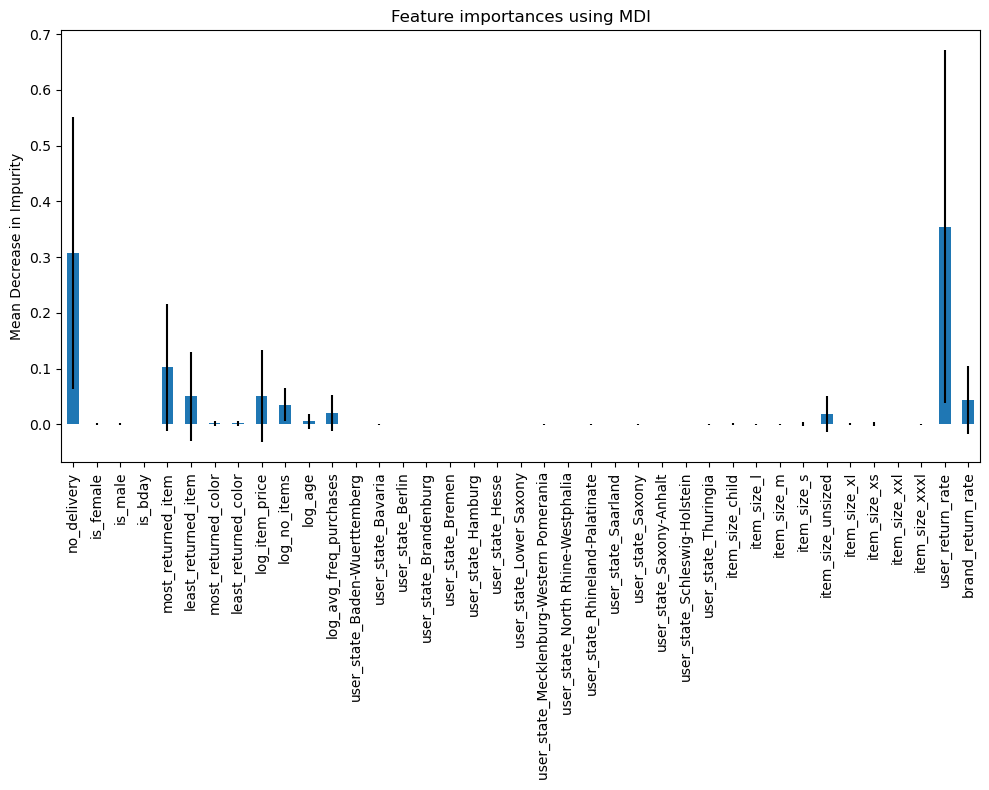

In [216]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
rf_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 8))
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") # Mean Decrease in Impurity
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

# SVM

##### Baseline

In [102]:
svm_baseline = LinearSVC(random_state=42)
svm_baseline.fit(X_train, y_train)

evaluate_model_binary(svm_baseline, X_test, y_test)

{'AUC': 0.6860975562720371,
 'Accuracy': 0.6860975562720372,
 'Precision': 0.6503995737879595,
 'Recall': 0.6725429704715734,
 'F1 Score': 0.6612859541736635}

##### Tuning

Algorithm

In [103]:
# Initialize Model
svm = LinearSVC(C=1.0, random_state=42, max_iter=1000)

In [104]:
param_grid = {
    'dual': [True, False]
}

custom_grid_search_acc(svm, param_grid, kfold_data)

Params: {'dual': True} | Avg. Acc Score: 0.6795
Params: {'dual': False} | Avg. Acc Score: 0.67951

Params Avg. Acc Score: 0.67951
Best Params: {'dual': False}


Regularization

In [105]:
# Re-Initialize Model
svm = LinearSVC(dual=False, random_state=42, max_iter=1000)

# Step 1
param_grid = {
    'C': [0.1, 1, 10, 100]
}

custom_grid_search_acc(svm, param_grid, kfold_data)

Params: {'C': 0.1} | Avg. Acc Score: 0.67933
Params: {'C': 1} | Avg. Acc Score: 0.67951
Params: {'C': 10} | Avg. Acc Score: 0.6795
Params: {'C': 100} | Avg. Acc Score: 0.67949

Params Avg. Acc Score: 0.67951
Best Params: {'C': 1}


In [110]:
# Re-Initialize Model
svm = LinearSVC(dual=False, random_state=42, max_iter=1000)

# Step 2
param_grid = {
    'C': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
}

custom_grid_search_acc(svm, param_grid, kfold_data)

Params: {'C': 0.5} | Avg. Acc Score: 0.6795
Params: {'C': 0.6} | Avg. Acc Score: 0.67949
Params: {'C': 0.7} | Avg. Acc Score: 0.67949
Params: {'C': 0.8} | Avg. Acc Score: 0.67949
Params: {'C': 0.9} | Avg. Acc Score: 0.6795
Params: {'C': 1.0} | Avg. Acc Score: 0.67951
Params: {'C': 1.1} | Avg. Acc Score: 0.67951
Params: {'C': 1.2} | Avg. Acc Score: 0.67951
Params: {'C': 1.3} | Avg. Acc Score: 0.67951
Params: {'C': 1.4} | Avg. Acc Score: 0.67951
Params: {'C': 1.5} | Avg. Acc Score: 0.67949

Params Avg. Acc Score: 0.67951
Best Params: {'C': 1.3}


Efficiency

In [112]:
# Re-Initialize Model
svm = LinearSVC(C=1.3, dual=False, random_state=42)

param_grid = {
    'max_iter': [500, 1000, 2000]
}

custom_grid_search_acc(svm, param_grid, kfold_data)

Params: {'max_iter': 500} | Avg. Acc Score: 0.67951
Params: {'max_iter': 1000} | Avg. Acc Score: 0.67951
Params: {'max_iter': 2000} | Avg. Acc Score: 0.67951

Params Avg. Acc Score: 0.67951
Best Params: {'max_iter': 500}


##### Final Model

In [113]:
param_grid = {'C':1.3, 'dual':False, 'random_state':42, 'max_iter':500}

svm = LinearSVC()
svm.set_params(**param_grid)
svm.fit(X_train, y_train)

evaluate_model_binary(svm, X_test, y_test)

{'AUC': 0.6860975562720371,
 'Accuracy': 0.6860975562720372,
 'Precision': 0.6503995737879595,
 'Recall': 0.6725429704715734,
 'F1 Score': 0.6612859541736635}

# XGBoost

##### Baseline

In [21]:
xgb_baseline = XGBClassifier(objective='binary:logistic', random_state=42)
xgb_baseline.fit(X_train, y_train)

evaluate_model_probability(xgb_baseline, X_test, y_test)

{'AUC': 0.7408183946571681,
 'Accuracy': 0.6862277478161951,
 'Precision': 0.6380876334963569,
 'Recall': 0.7043851917144116,
 'F1 Score': 0.6695993715632365}

##### Tuning

Method

In [151]:
param_grid = {
    'objective': ['binary:logistic', 'reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'random_state': [42]
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'objective': 'binary:logistic', 'booster': 'gbtree', 'random_state': 42} | Avg. AUC Score: 0.72417
Params: {'objective': 'binary:logistic', 'booster': 'gblinear', 'random_state': 42} | Avg. AUC Score: 0.74465
Params: {'objective': 'reg:squarederror', 'booster': 'gbtree', 'random_state': 42} | Avg. AUC Score: 0.73718
Params: {'objective': 'reg:squarederror', 'booster': 'gblinear', 'random_state': 42} | Avg. AUC Score: 0.72303

Params Avg. AUC Score: 0.74465
Best Params: {'objective': 'binary:logistic', 'booster': 'gblinear', 'random_state': 42}


Regularization

In [157]:
# Step 1
param_grid = {
    'lambda': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'random_state': [42],
    'objective': ['binary:logistic'],
    'booster': ['gblinear']
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74457
Params: {'lambda': 0.1, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73287
Params: {'lambda': 0.2, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.71939
Params: {'lambda': 0.3, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.71137
Params: {'lambda': 0.4, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.70626
Params: {'lambda': 0.5, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.70272

Params Avg. AUC Score: 0.74457
Best Params: {'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'}


In [51]:
# Step 2
param_grid = {
    'lambda': [0, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
    'random_state': [42],
    'objective': ['binary:logistic'],
    'booster': ['gblinear']
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74459
Params: {'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.7446
Params: {'lambda': 5e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74399
Params: {'lambda': 0.0001, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74337
Params: {'lambda': 0.0005, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.7414
Params: {'lambda': 0.001, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74025
Params: {'lambda': 0.005, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73908
Params: {'lambda': 0.01, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Scor

In [53]:
# Step 3
param_grid = {
    'lambda': [0.000008, 0.000009, 0.00001, 0.00002, 0.00003],
    'random_state': [42],
    'objective': ['binary:logistic'],
    'booster': ['gblinear']
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'lambda': 8e-06, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74458
Params: {'lambda': 9e-06, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74458
Params: {'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74462
Params: {'lambda': 2e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74448
Params: {'lambda': 3e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74438

Params Avg. AUC Score: 0.74462
Best Params: {'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'}


Learning Rate

In [55]:
# Step 1
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
    'lambda': [0.00001],
    'random_state': [42],
    'objective': ['binary:logistic'],
    'booster': ['gblinear']
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'eta': 0.01, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.7596
Params: {'eta': 0.05, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.75246
Params: {'eta': 0.1, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74645
Params: {'eta': 0.2, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74414
Params: {'eta': 0.3, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74409

Params Avg. AUC Score: 0.7596
Best Params: {'eta': 0.01, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'}


In [58]:
# Step 2
param_grid = {
    'eta': [0.0005, 0.001, 0.005, 0.01, 0.015, 0.02, 0.025],
    'lambda': [0.00001],
    'random_state': [42],
    'objective': ['binary:logistic'],
    'booster': ['gblinear']
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'eta': 0.0005, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.75286
Params: {'eta': 0.001, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.75342
Params: {'eta': 0.005, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.75702
Params: {'eta': 0.01, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.7596
Params: {'eta': 0.015, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.76038
Params: {'eta': 0.02, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.76
Params: {'eta': 0.025, 'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.75896

Params Avg. AUC S

Use XGB Model from XGB package

1. Get No. of Boosting Rounds
2. Get Feature Importance

In [49]:
param_grid = {
    'eta': 0.015,
    'lambda': 0.00001,
    'random_state': 42,
    'objective': 'binary:logistic',
    'booster': 'gblinear',
    'eval_metric': 'auc'
}

# Create DMatrix to store data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Find no. of boosting rounds required
rounds = xgb.train(
    param_grid,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=20
)

print("Convergence in {} rounds".format(rounds.best_iteration+1))

[0]	Test-auc:0.75618
[20]	Test-auc:0.75981
[40]	Test-auc:0.76270
[60]	Test-auc:0.76486
[80]	Test-auc:0.76635
[100]	Test-auc:0.76725
[120]	Test-auc:0.76767
[140]	Test-auc:0.76771
[143]	Test-auc:0.76769
Convergence in 134 rounds


##### Final Model

In [19]:
param_grid = {
    'n_estimators': rounds.best_iteration+1, # 134 boosting rounds
    'eta': 0.015,
    'lambda': 0.00001,
    'random_state': 42,
    'objective': 'binary:logistic',
    'booster': 'gblinear',
    'eval_metric': 'auc'
}

xgbc = XGBClassifier(**param_grid)
xgbc.fit(X_train, y_train)

evaluate_model_probability(xgbc, X_test, y_test, threshold=0.49)

{'AUC': 0.7677520477229672,
 'Accuracy': 0.6995670556248315,
 'Precision': 0.6447876447876448,
 'Recall': 0.7360070515645659,
 'F1 Score': 0.6873842354393909}

##### Feature Importance

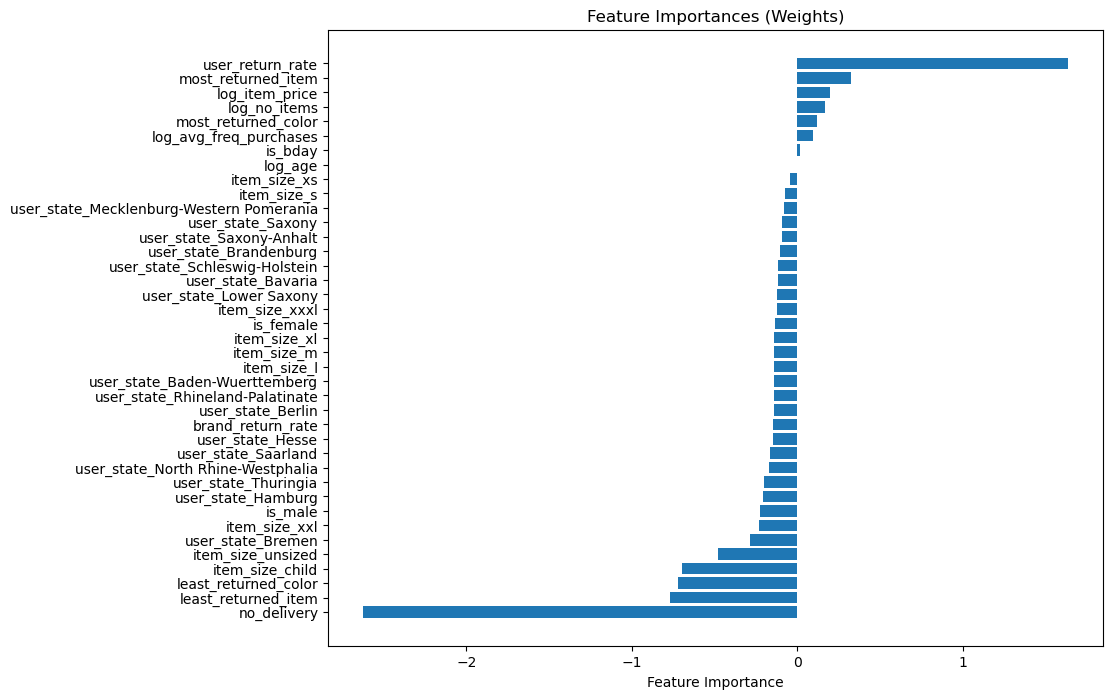

In [18]:
param_grid = {
    'eta': 0.015,
    'lambda': 0.00001,
    'random_state': 42,
    'objective': 'binary:logistic',
    'booster': 'gblinear',
    'eval_metric': 'auc'
}

xgb_fi = xgb.train(
    param_grid,
    dtrain,
    num_boost_round=rounds.best_iteration+1,
    evals=[(dtest, "Test")],
    verbose_eval=0
)

# Get the feature importances (weights)
feature_importances_dict = xgb_fi.get_score(importance_type='weight')

# Sort the dictionary by value in descending order
sorted_importances_dict = dict(sorted(feature_importances_dict.items(), key=lambda item: item[1], reverse=True))

# Create lists of feature names and importances
features = list(sorted_importances_dict.keys())
importances = list(sorted_importances_dict.values())

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(features))
ax.barh(y_pos, importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)  # Convert column names to strings
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importances (Weights)')

plt.show()

# DNN

##### Baseline

In [12]:
np.random.seed(1)

dnn_model = Sequential()
keras.backend.clear_session()
dnn_model.add(Dense(40, input_shape=(X_train.shape[1],))) # Input layer
dnn_model.add(Dense(27,activation='relu')) # Hidden layer
dnn_model.add(Dense(1, activation='sigmoid')) # Output layer
dnn_model.compile(loss='binary_crossentropy',metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=11, batch_size=32)

evaluate_dnn_probability(dnn_model,X_test,y_test)


625/625 [==============================] - 1s 2ms/step


{'AUC': 0.7519112679470275,
 'Accuracy': 0.6889989678275594,
 'Precision': 0.6296331050014076,
 'Recall': 0.7393124724548259,
 'F1 Score': 0.6800790553894491}

##### Tuning

Complexity

In [14]:
# Tuning nodes in input and hidden layers
dnn_params = { 
    'input': [35,40,45],  
    'hidden':[25,27,30],
    'epochs': [11], 
}

dnn_model = Sequential()
best_history = custom_grid_search_dnn_auc(dnn_model, dnn_params, kfold_data)

500/500 [==============================] - 1s 1ms/step
Params: {'input': 35, 'hidden': 25, 'epochs': 11} | Avg. AUC Score: 0.74007
500/500 [==============================] - 1s 899us/step
Params: {'input': 35, 'hidden': 27, 'epochs': 11} | Avg. AUC Score: 0.74021
500/500 [==============================] - 1s 2ms/step
Params: {'input': 35, 'hidden': 30, 'epochs': 11} | Avg. AUC Score: 0.71585
500/500 [==============================] - 1s 2ms/step
Params: {'input': 40, 'hidden': 25, 'epochs': 11} | Avg. AUC Score: 0.62327
500/500 [==============================] - 1s 1ms/step
Params: {'input': 40, 'hidden': 27, 'epochs': 11} | Avg. AUC Score: 0.62326
500/500 [==============================] - 2s 2ms/step
Params: {'input': 40, 'hidden': 30, 'epochs': 11} | Avg. AUC Score: 0.62326
500/500 [==============================] - 2s 2ms/step
Params: {'input': 45, 'hidden': 25, 'epochs': 11} | Avg. AUC Score: 0.62326
500/500 [==============================] - 2s 3ms/step
Params: {'input': 45, 'hid

In [11]:
# Tuning number of epochs
# Tuning nodes in input and hidden layers
dnn_params = { 
    'input': [35],  
    'hidden':[27],
    'epochs': [5,10,11,15,20], 
}

dnn_model = Sequential()
best_history = custom_grid_search_dnn_auc(dnn_model, dnn_params, kfold_data)

500/500 [==============================] - 0s 734us/step
Params: {'input': 35, 'hidden': 27, 'epochs': 5} | Avg. AUC Score: 0.74168
500/500 [==============================] - 2s 2ms/step
Params: {'input': 35, 'hidden': 27, 'epochs': 10} | Avg. AUC Score: 0.74084
500/500 [==============================] - 1s 1ms/step
Params: {'input': 35, 'hidden': 27, 'epochs': 11} | Avg. AUC Score: 0.68884
500/500 [==============================] - 1s 1ms/step
Params: {'input': 35, 'hidden': 27, 'epochs': 15} | Avg. AUC Score: 0.50009
500/500 [==============================] - 1s 2ms/step
Params: {'input': 35, 'hidden': 27, 'epochs': 20} | Avg. AUC Score: 0.5

Params Avg. AUC Score: 0.74168
Best Params: {'input': 35, 'hidden': 27, 'epochs': 5}


##### Final Model

In [13]:
dnn_params = { 
    'input': 35,  
    'hidden': 27,
    'epochs': 5, 
}

dnn_model = Sequential()
dnn_model.add(Dense(dnn_params['input'], input_shape=(X_train.shape[1],)))
dnn_model.add(Dense(dnn_params['hidden'], activation='relu')) # hidden layer 
dnn_model.add(Dense(1, activation='sigmoid'))  # Output layer
dnn_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer="adam")
dnn_model.fit(X_train, y_train, epochs=dnn_params['epochs'], batch_size=32, verbose=0)     

evaluate_dnn_probability(dnn_model, X_test, y_test, threshold=0.46)

625/625 [==============================] - 1s 812us/step


{'AUC': 0.7531119843757237,
 'Accuracy': 0.6918925122150894,
 'Precision': 0.6396132434808087,
 'Recall': 0.7215733803437637,
 'F1 Score': 0.6781258089567693}

# Metrics for the best model - XGBoost

In [47]:
param_grid = {
    'n_estimators': 134,
    'eta': 0.015,
    'lambda': 0.00001,
    'random_state': 42,
    'objective': 'binary:logistic',
    'booster': 'gblinear',
    'eval_metric': 'auc'
}

xgbc = XGBClassifier(**param_grid)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.015, eval_metric='auc',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1e-05,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=134,
              n_jobs=None, ...)

Performance

In [145]:
# Balance
evaluate_model_probability(xgbc, X_test, y_test, threshold=0.49)

{'AUC': 0.7677342406908003,
 'Accuracy': 0.6997594583128047,
 'Precision': 0.6450086889360881,
 'Recall': 0.7361172322609079,
 'F1 Score': 0.6875578882371103}

In [61]:
# Prioritising Recall
evaluate_model_probability(xgbc, X_test, y_test, threshold=0.45)

{'AUC': 0.7677382095761913,
 'Accuracy': 0.696539608003629,
 'Precision': 0.6206335616438357,
 'Recall': 0.7986998677831644,
 'F1 Score': 0.6984968201965697}

ROC-AUC Curve

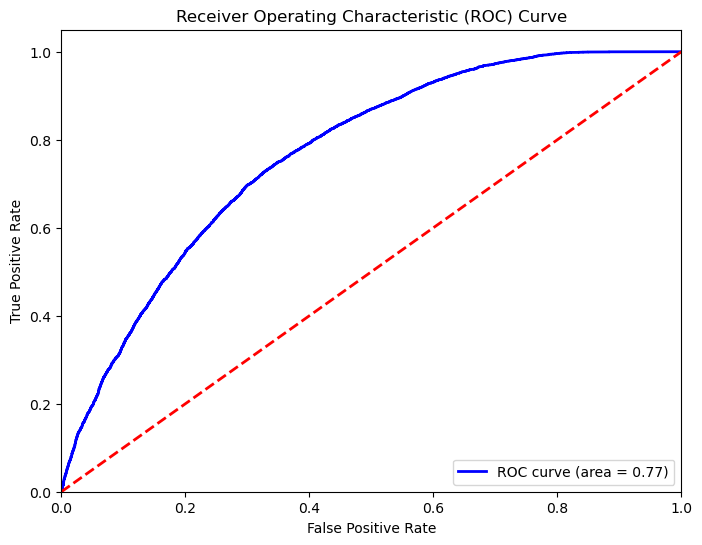

In [146]:
def plot_roc_auc_curve(model, X_test, y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_auc_curve(xgbc, X_test, y_test)

Confusion Matrix

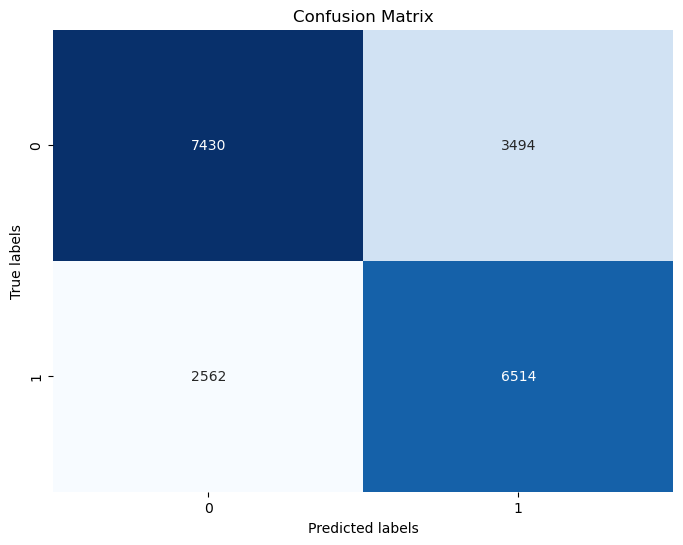

In [147]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(xgbc, X_test, y_test)

Feature Importance

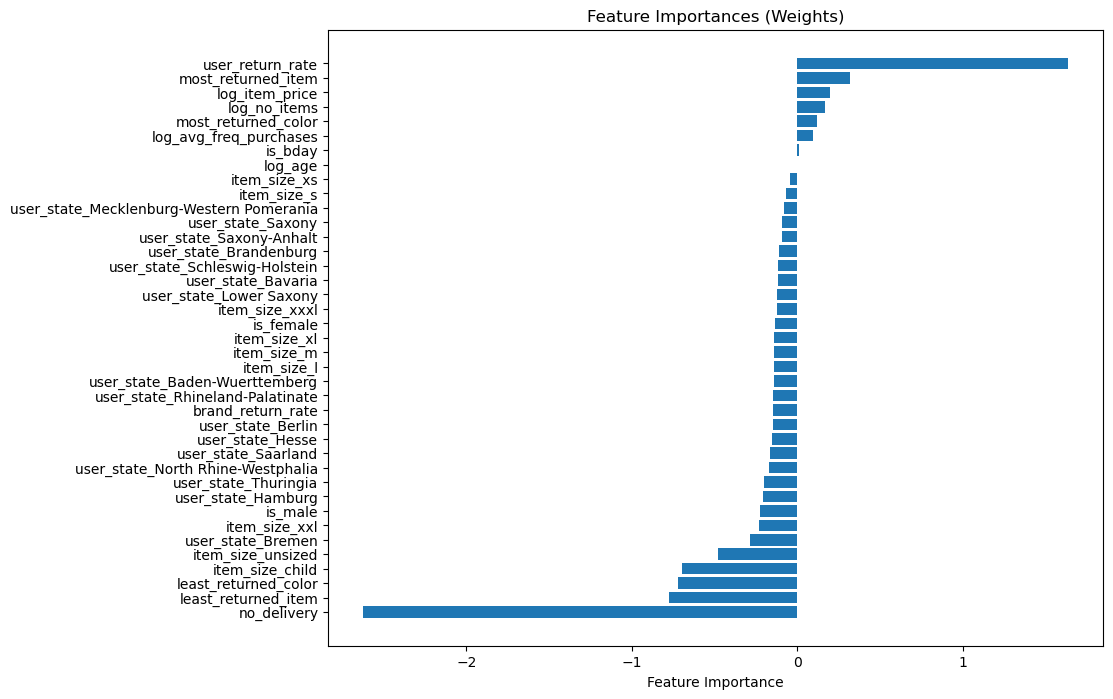

In [50]:
xgb_bm = xgb.train(
    param_grid,
    dtrain,
    num_boost_round=rounds.best_iteration+1,
    evals=[(dtest, "Test")],
    verbose_eval=0
)

# Get the feature importances (weights)
feature_importances_dict = xgb_bm.get_score(importance_type='weight')

# Sort the dictionary by value in descending order
sorted_importances_dict = dict(sorted(feature_importances_dict.items(), key=lambda item: item[1], reverse=True))

# Create lists of feature names and importances
features = list(sorted_importances_dict.keys())
importances = list(sorted_importances_dict.values())

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(features))
ax.barh(y_pos, importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)  # Convert column names to strings
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importances (Weights)')

plt.show()

### Extended Analysis of XGBoost

We try only keeping the top most significant variables, tune the parameters, and see how it affects the AUC score.

Note that the length of the bars in the feature importance plot represent the value of the coefficients.

##### Cross Validation Preparation

Remove brand_return_rate from computation as it's not one of the top variables.

In [21]:
def prepare_kfold_data(X_train, y_train, k=5, default_fill_value=0.5):
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    data_arrays = []

    for train_index, val_index in kf.split(X_train):
        # Step 1: Split data into train and validation folds
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Step 2: Perform preprocessing on train fold
        user_return_rates = X_train_fold.groupby('user_id')['return'].mean()
        
        X_train_fold['user_return_rate'] = X_train_fold['user_id'].map(user_return_rates)
        
        # Step 3: Map values to validation fold
        X_val_fold['user_return_rate'] = X_val_fold['user_id'].map(user_return_rates).fillna(default_fill_value)
        
        # Step 4: Drop unnecessary columns
        X_train_fold.drop(['return', 'user_id'], axis=1, inplace=True)
        X_val_fold.drop(['return', 'user_id'], axis=1, inplace=True)
        
        # Append data arrays
        data_arrays.append((X_train_fold, y_train_fold, X_val_fold, y_val_fold))

    return data_arrays

In [22]:
# Create train test split for CV evaluation
X = cv[['user_id', 'return', 'no_delivery', 'least_returned_item', 'item_size_child', 'least_returned_color', 'item_size_unsized', 
        'user_state_Bremen', 'item_size_xxl', 'most_returned_item', 'log_item_price']]
y = cv['return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get kfold data
kfold_data = prepare_kfold_data(X_train, y_train, k=5, default_fill_value=0.5)

/var/folders/4f/3w_37fps2jl_9bqnhfpl8d8h0000gn/T/ipykernel_1125/1311647249.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['user_return_rate'] = X_train_fold['user_id'].map(user_return_rates)
/var/folders/4f/3w_37fps2jl_9bqnhfpl8d8h0000gn/T/ipykernel_1125/1311647249.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold['user_return_rate'] = X_val_fold['user_id'].map(user_return_rates).fillna(default_fill_value)
/var/folders/4f/3w_37fps2jl_9bqnhfpl8d8h0000gn/T/ipykernel_1125/13116

In [23]:
# Look at kfold data
kfold_data[0]

(       no_delivery  least_returned_item  item_size_child  \
 64470            0                    0                0   
 45557            0                    0                0   
 27614            0                    0                0   
 13568            0                    0                0   
 92726            1                    0                0   
 ...            ...                  ...              ...   
 82386            0                    0                0   
 6265             0                    0                0   
 54886            0                    0                0   
 860              0                    0                0   
 15795            1                    1                0   
 
        least_returned_color  item_size_unsized  user_state_Bremen  \
 64470                     0                  0                  0   
 45557                     0                  0                  0   
 27614                     0                  0         

##### Model Evaluation Preparation

In [24]:
# Create train test split for model evaluation
X = df[['user_return_rate', 'no_delivery', 'least_returned_item', 'item_size_child', 'least_returned_color', 'item_size_unsized', 
        'user_state_Bremen', 'item_size_xxl', 'most_returned_item', 'log_item_price']]
y = df['return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(79999, 10)
(79999,)
(20000, 10)
(20000,)


##### Baseline

In [25]:
xgb_baseline = XGBClassifier(objective='binary:logistic', random_state=42)
xgb_baseline.fit(X_train, y_train)

evaluate_model_probability(xgb_baseline, X_test, y_test)

{'AUC': 0.7323198309599768,
 'Accuracy': 0.6804220804213381,
 'Precision': 0.6263990737167117,
 'Recall': 0.7152930806522697,
 'F1 Score': 0.6679012345679013}

##### Tuning

Method

In [26]:
param_grid = {
    'objective': ['binary:logistic', 'reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'random_state': [42]
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'objective': 'binary:logistic', 'booster': 'gbtree', 'random_state': 42} | Avg. AUC Score: 0.71798
Params: {'objective': 'binary:logistic', 'booster': 'gblinear', 'random_state': 42} | Avg. AUC Score: 0.73943
Params: {'objective': 'reg:squarederror', 'booster': 'gbtree', 'random_state': 42} | Avg. AUC Score: 0.73122
Params: {'objective': 'reg:squarederror', 'booster': 'gblinear', 'random_state': 42} | Avg. AUC Score: 0.71903

Params Avg. AUC Score: 0.73943
Best Params: {'objective': 'binary:logistic', 'booster': 'gblinear', 'random_state': 42}


Regularization

In [27]:
# Step 1
param_grid = {
    'lambda': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'random_state': [42],
    'objective': ['binary:logistic'],
    'booster': ['gblinear']
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73943
Params: {'lambda': 0.1, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.72429
Params: {'lambda': 0.2, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.71095
Params: {'lambda': 0.3, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.70266
Params: {'lambda': 0.4, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.69731
Params: {'lambda': 0.5, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.69362

Params Avg. AUC Score: 0.73943
Best Params: {'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'}


In [28]:
# Step 2
param_grid = {
    'lambda': [0, 0.00001, 0.00002, 0.00003],
    'random_state': [42],
    'objective': ['binary:logistic'],
    'booster': ['gblinear']
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73943
Params: {'lambda': 1e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73942
Params: {'lambda': 2e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73929
Params: {'lambda': 3e-05, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73913

Params Avg. AUC Score: 0.73943
Best Params: {'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'}


Learning Rate

In [30]:
# Step 1
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
    'lambda': [0],
    'random_state': [42],
    'objective': ['binary:logistic'],
    'booster': ['gblinear']
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'eta': 0.01, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74561
Params: {'eta': 0.05, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74281
Params: {'eta': 0.1, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74113
Params: {'eta': 0.2, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73996
Params: {'eta': 0.3, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73958

Params Avg. AUC Score: 0.74561
Best Params: {'eta': 0.01, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'}


In [31]:
# Step 2
param_grid = {
    'eta': [0.001, 0.005, 0.01, 0.015, 0.2],
    'lambda': [0],
    'random_state': [42],
    'objective': ['binary:logistic'],
    'booster': ['gblinear']
}

custom_grid_search_xgb_auc(param_grid, kfold_data)

Params: {'eta': 0.001, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74042
Params: {'eta': 0.005, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74348
Params: {'eta': 0.01, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74561
Params: {'eta': 0.015, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.74633
Params: {'eta': 0.2, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'} | Avg. AUC Score: 0.73997

Params Avg. AUC Score: 0.74633
Best Params: {'eta': 0.015, 'lambda': 0, 'random_state': 42, 'objective': 'binary:logistic', 'booster': 'gblinear'}


Use XGB Model from XGB package

1. Get No. of Boosting Rounds
2. Get Feature Importance

In [34]:
param_grid = {
    'eta': 0.015,
    'lambda': 0,
    'random_state': 42,
    'objective': 'binary:logistic',
    'booster': 'gblinear',
    'eval_metric': 'auc'
}

# Create DMatrix to store data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Find no. of boosting rounds required
rounds = xgb.train(
    param_grid,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=20
)

print("Convergence in {} rounds".format(rounds.best_iteration+1))

[0]	Test-auc:0.74444
[20]	Test-auc:0.74764
[40]	Test-auc:0.75032
[60]	Test-auc:0.75233
[80]	Test-auc:0.75370
[100]	Test-auc:0.75462
[120]	Test-auc:0.75519
[140]	Test-auc:0.75535
[158]	Test-auc:0.75538
Convergence in 149 rounds


##### Final Model

In [35]:
param_grid = {
    'n_estimators': rounds.best_iteration+1, # 149 boosting rounds
    'eta': 0.015,
    'lambda': 0,
    'random_state': 42,
    'objective': 'binary:logistic',
    'booster': 'gblinear',
    'eval_metric': 'auc'
}

xgbc = XGBClassifier(**param_grid)
xgbc.fit(X_train, y_train)

evaluate_model_probability(xgbc, X_test, y_test, threshold=0.53)

{'AUC': 0.7554016631031758,
 'Accuracy': 0.6886348994995513,
 'Precision': 0.6327878265862762,
 'Recall': 0.7285147642133099,
 'F1 Score': 0.6772855313700386}

Original Best XGBoost Model (Classification Threshold = 0.49)

- AUC: 0.7677342406908003
- Accuracy: 0.6997594583128047
- Precision: 0.6450086889360881
- Recall: 0.7361172322609079
- F1 Score: 0.6875578882371103

We observe an approximate 1% drop in AUC and accuracy from limiting the variables to the top 10 most important variables. Perhaps a middle ground approach would be to remove the least important features such as is_bday, log_avg_freq_purchases, and log_age.